# **Types of Sequential Data**


In common machine learning tasks, it is assumed that the data is identically and independently distributed (i.i.d.). However, when dealing with changes in distribution of the underlying data generating process, or working with data that has temporal dependence, this i.i.d. assumption breaks.

Practitioners and data scientists should be able to model such data by drawing from a variety of tools for sequential data analysis. In this lab, we introduce forms of sequential data, and basic concepts needed to understand components of a time-series.


## Objectives

After completing this lab you will be able to:

*   Describe various forms of sequential data, and common tasks that can be modeled using sequential data
*   Decompose a time-series and perform time-series imputation
*   Pre-process and vectorize a text dataset
*   Pre-process and visualize an audio dataset, and create spectrograms


***


## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Importing Required Libraries

*We recommend you import all required libraries in one place (here):*


In [2]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
print(tf. __version__)

import keras 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import os
import pathlib
from scipy import signal
from scipy.io import wavfile
import re
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

sns.set_context('notebook')
sns.set_style('white')

2.12.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Background

In machine learning, it is quite common to assume that the data are identically and independently distributed or i.i.d. This implies that the generative process does not have any memory of past samples to generate new samples.
This assumption is usually violated when dealing with sequential data as samples depend on past information, that is, they are reliant on one another due to their sequential order.
Examples where data depends on past information may include weather. For instance, it's not likely to snow if the temperature is extremely hot the day before. In financial time series, the price of the stock is not only determined by the fundamentals of the company but the price of the stock the day before; we will see more examples later on.
There are many method to study time series data; in this section, we will study some of the classic methods. These methods are precursors to Recurrent Neural Networks (RNNs), a well-known method, well-suited to model these forms of sequential data that we will cover in the next few sections.


## The i.i.d. Assumption


In this lab, we will be dealing with data that, rather than being drawn i.i.d., from some joint distribution $P(x, y)$, actually consists of sequences of $(x, y)$ pairs that show some sequential correlation. This means that values close to the x and y values are likely to be related to and/or dependent on each other.


So when the points in the data set are dependent on the other points in the data set, the data is termed sequential.


The sequential supervised learning problem can be formulated as follows:


Let ${(x_i, y_i)}^N\_{i=1}$ be a set of N training examples. In a part-of-speech tagging task, one $(x_i, y_i)$ pair might consist of $x_i =$ do you want fries and $y_i =$ verb pronoun verb noun. Our goal is to build a model, $h$, that predicts the next label sequence, $y = h(x)$, given an input sequence, $x$. Here the task is to predict the $t+1$st element of the sequence $(y\_1,...,y_t)$.


Let us walk through an example to highlight the issues when working with non-i.i.d. data. We will be using financial quotations from various energy companies.


In [7]:
pip install skillsnetwork

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.6 MB/s eta 0:00:00


In [9]:
import skillsnetwork


In [10]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/financial-data.zip")


  0%|          | 0/12 [00:00<?, ?it/s]

Saved to '.'


In [11]:
import pandas as pd

symbols = {"TOT": "Total", "XOM": "Exxon", "CVX": "Chevron",
           "COP": "ConocoPhillips", "VLO": "Valero Energy"}
template_name = ("./financial-data/{}.csv")

quotes = {}
for symbol in symbols:
    data = pd.read_csv(
        template_name.format(symbol), index_col=0, parse_dates=True
    )
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)
quotes .head()

,Total,Exxon,Chevron,ConocoPhillips,Valero Energy
date,,,,,
2003-01-02,71.62,35.00,67.20,48.80,37.04
2003-01-03,72.12,35.25,67.82,49.53,38.13
2003-01-06,72.93,35.45,68.34,49.50,37.37
2003-01-07,72.40,36.05,69.75,49.85,37.46
2003-01-08,69.51,35.15,68.46,48.44,36.51


Let us plot a few financial quotations.


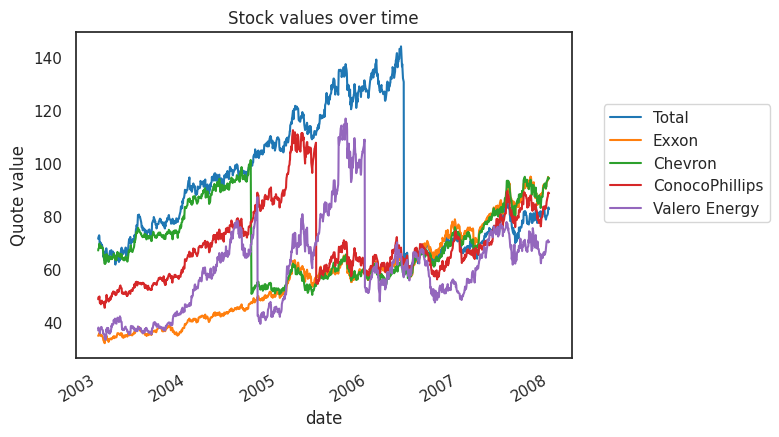

In [12]:
import matplotlib.pyplot as plt

quotes.plot()
plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Stock values over time")

We want to predict the quotation of Chevron using all other energy companies’ quotes. We will use the decision tree regressor that is expected to overfit and thus not generalize to unseen data. We will start off by splitting our data into a testing and training set.


In [13]:
data, target = quotes.drop(columns=["Chevron"]), quotes["Chevron"]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0)

we have our features


In [14]:
 data

,Total,Exxon,ConocoPhillips,Valero Energy
date,,,,
2003-01-02,71.62,35.00,48.80,37.04
2003-01-03,72.12,35.25,49.53,38.13
2003-01-06,72.93,35.45,49.50,37.37
2003-01-07,72.40,36.05,49.85,37.46
2003-01-08,69.51,35.15,48.44,36.51
...,...,...,...,...
2007-12-24,80.55,93.51,87.02,70.42
2007-12-26,81.10,93.66,87.68,70.92
2007-12-27,82.35,94.94,88.92,71.10


and target Chevron


In [15]:
target

date
2003-01-02    67.20
2003-01-03    67.82
2003-01-06    68.34
2003-01-07    69.75
2003-01-08    68.46
              ...  
2007-12-24    93.63
2007-12-26    94.31
2007-12-27    94.80
2007-12-28    94.38
2007-12-31    94.37
Name: Chevron, Length: 1258, dtype: float64

Let’s now define our model:


In [16]:
regressor = DecisionTreeRegressor()

And now we apply a cross-validation strategy, to check the generalization performance of our model.


In [17]:
cv = ShuffleSplit(random_state=0)

In [18]:
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
# Affect the index of `target_predicted` to ease the plotting
target_predicted = pd.Series(target_predicted, index=target_test.index)
target_predicted 

date
2003-01-09    68.68
2004-12-17    52.57
2003-03-19    65.96
2006-11-29    70.46
2003-09-29    72.20
              ...  
2005-12-14    59.28
2006-12-22    72.83
2006-08-30    67.42
2004-10-28    53.44
2006-08-15    67.51
Length: 315, dtype: float64

Now we perform evaluation.


In [19]:
from sklearn.metrics import r2_score

test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: 0.83


We get outstanding generalization performance in terms of $R^2$. Let's plot the predictions against the ground truth.


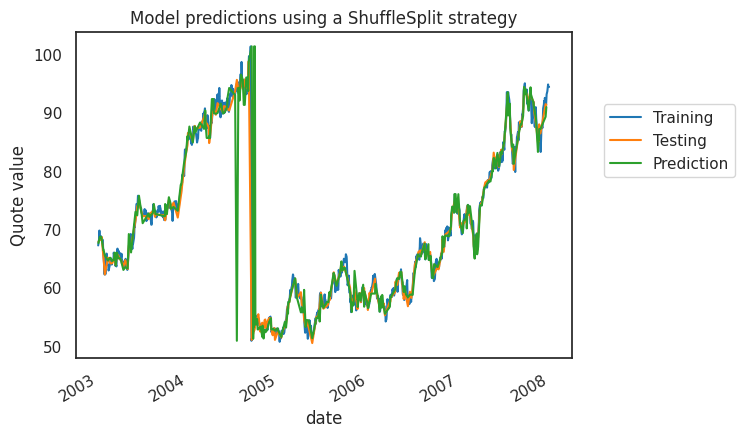

In [20]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a ShuffleSplit strategy")

The results are surprisingly very good, as we had originally expected the model to overfit and not generalize on unseen test sets. Let us now investigate why this is the case.

We used a cross-validation method that shuffles data and splits. We will simplify this procedure by not shuffling our data and plotting the results obtained.


In [21]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=False, random_state=0,
)
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
target_predicted = pd.Series(target_predicted, index=target_test.index)

In [22]:
test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: -2.18


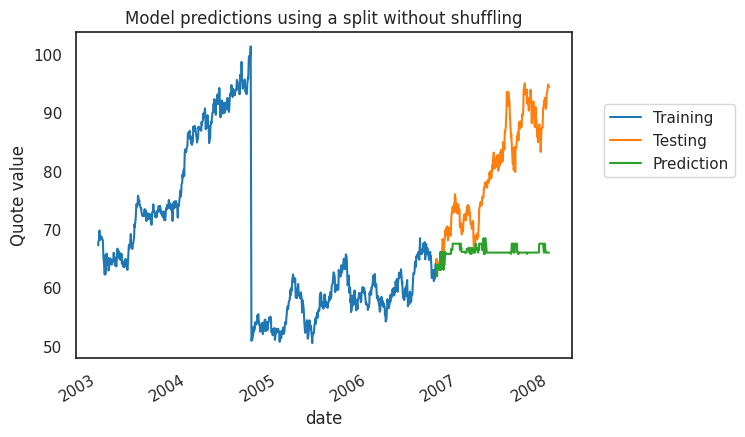

In [23]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a split without shuffling")

Now we see that our model performs worse than just predicting the mean of the target. Why is that?


In this dataset, and all other similar time series datasets, the testing samples follow some of the training sample. As mentioned before, in time-series subsequent samples are dependent on previous samples; that is, there is a relationship between sample $t$ and sample $t+1$. We are clearly violating the i.i.d. assumption. The model's prediction would be close to true values even when it doesn't learn anything, because of data leakage and because it could have just memorized the training dataset.


## Understanding Sequential Modeling


Sequential modeling can be described as the process of forecasting a sequence of values from a set of input values, similar to what we saw in the previous section.

For example, consider a time-series that represents how a patient's physiological values like continuous heart rate, ECG, breathing rate, and temperature, change over time. One possible sequential modeling task could be to forecast their disease trajectory or predict their medical condition at some future time.


Text prediction is another example. For example, you can be given a sequence of words, and your modeling task could be to predict the next word based on the sequence of the previous word/phrase and a set of pre-loaded conditions and rules.


## Forms of Sequential Data

Sequential data contains elements that are ordered into sequences. For example, time series (like stock values or sensor measurements), gene sequences (${C,G,A,T}$), speech, text (${a,...,z,0,...,9,...}$), video clips, and musical notes, and so on.

To summarize, sequential data has some temporal coherence, and can be of arbitrary lengths. A lot of tasks can be modeled from these types of data. For example:

*   text classification, such as spam email or not
*   language translation, such as French to English
*   time-series forecasting, such as stock prices prediction

Let us look at a few common sequential data sets, and understand pre-processing techniques associated with each.


### Working with time-series data


Time series are special types of sequences that consist of random variables indexed by time. In particular, the random variables can be dependent and their distribution might change over time, so time-series also violate the i.i.d. assumption.


#### Time-series decomposition


Time series data can exhibit various patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category. These include trend, seasonality, and cycles, which we will now explain using examples.


*   **trend**: A trend is observed when there is an increasing or decreasing slope observed in the time series. In the following time series, we see an increasing pattern.


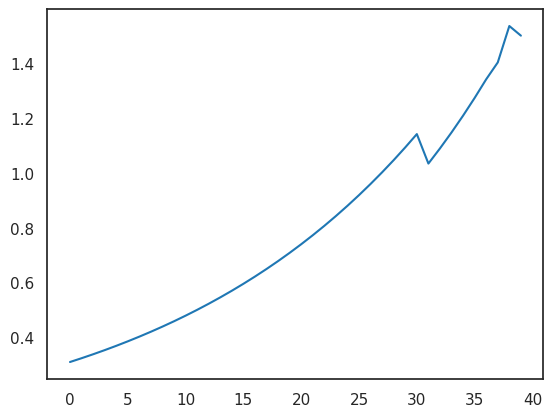

In [24]:
trend = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/guinearice.csv', parse_dates=['date'], index_col='date')
plt.plot(trend.values)

*   **seasonality**: Seasonality represents a distinct repeated pattern observed between regular intervals due to seasonal factors, like month of the year, the day of the month, weekdays or even time of the day, festivals, and so on.


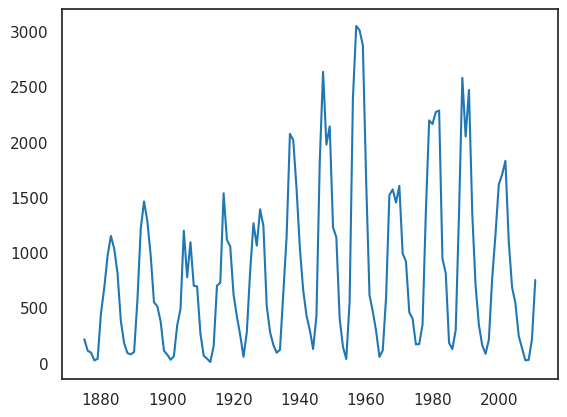

In [25]:
seasonality = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/sunspotarea.csv', parse_dates=['date'], index_col='date')
plt.plot(seasonality.value)

A time series can have both trend and seasonality, for example:


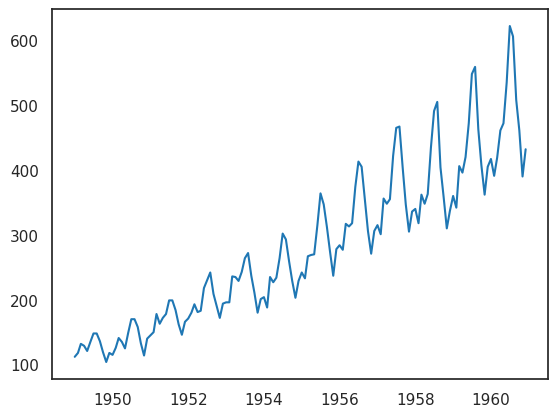

In [26]:
seasonality_trend = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/AirPassengers.csv', parse_dates=['date'], index_col='date')
plt.plot(seasonality_trend.value)

*   **cyclic**: Cyclicity is similar to seasonality, but it happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals, that is, if the patterns are not of fixed calendar-based frequencies, then the pattern is cyclic.


A time series can be modeled as an additive or multiplicative, wherein each observation in the series can be expressed as either a sum or a product of the components.

**Additive time series** \
\
$Value(t) = BaseLevel(t) + Trend(t) + Seasonality(t) + Error(t)$

**Multiplicative Time Series** \
\
$Value(t) = BaseLevel (t) X  Trend(t) X Seasonality(t) X Error(t)$


We can use functions like `seasonal_decompose` from the python package, `statsmodel`, to decompose our time-series into trend, seasonality, and the residual components.


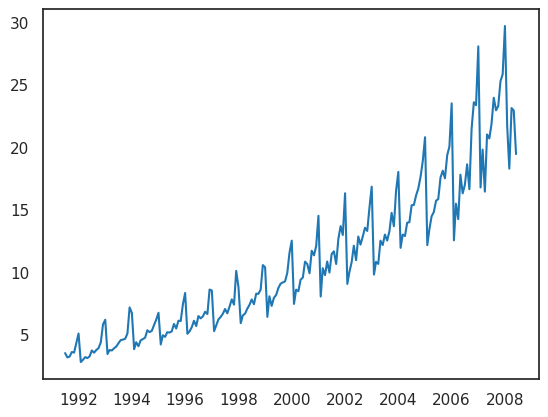

In [27]:
# Import Data
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/a10.csv', parse_dates=['date'], index_col='date')
plt.plot(df.value)

In [30]:
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


Let us start by performing additive decomposition. Note that by using `extrapolate_trend = 'freq'`, we impute missing values at the beginning of the time series.


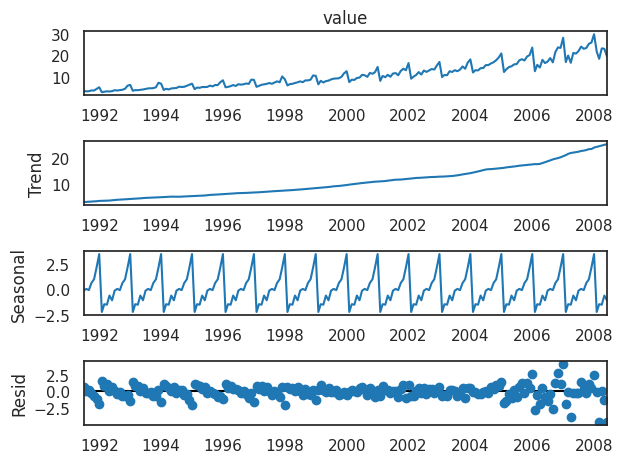

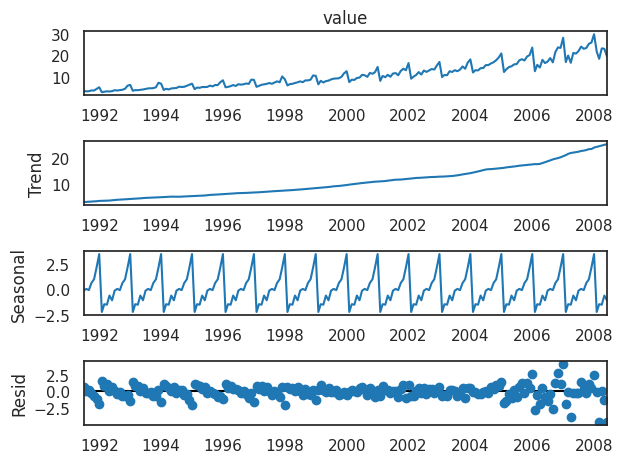

In [32]:
# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
result_add.plot()

Now, similarly we can try performing multiplicative decomposition:


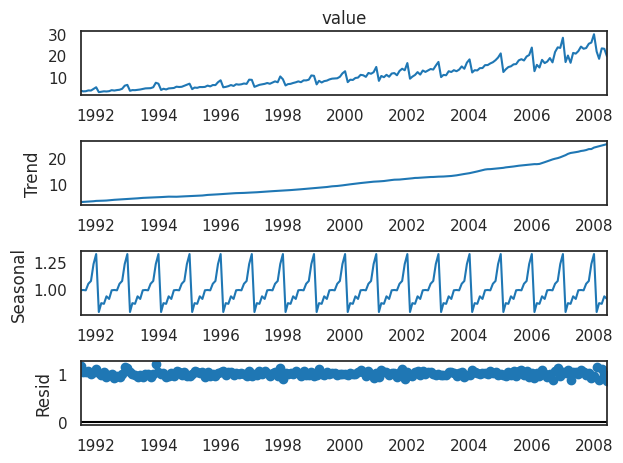

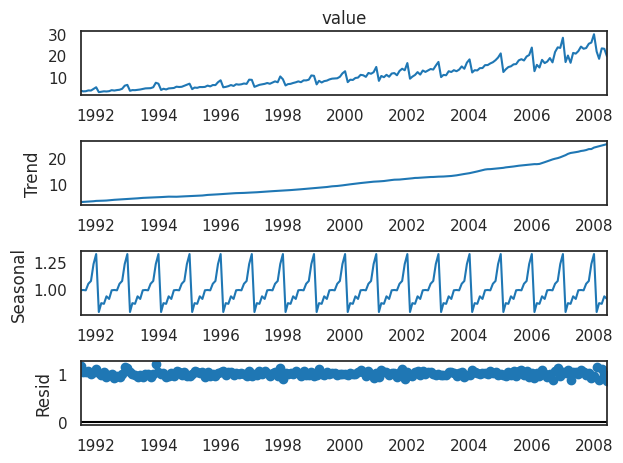

In [33]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

#Plot
result_mul.plot()

In this particular case, we see that with additive decomposition, some pattern is still left over, while with multiplicative decomposition, the result looks quite random, which is what we want.


So how do we detrend our time series? One way would be to subtract the trend component obtained from the time series decomposition we saw earlier.


In [35]:
result_mul.trend

date
1991-07-01     3.060085
1991-08-01     3.124765
1991-09-01     3.189445
1991-10-01     3.254125
1991-11-01     3.318805
                ...    
2008-02-01    24.037399
2008-03-01    24.298458
2008-04-01    24.559516
2008-05-01    24.820574
2008-06-01    25.081633
Name: trend, Length: 204, dtype: float64

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

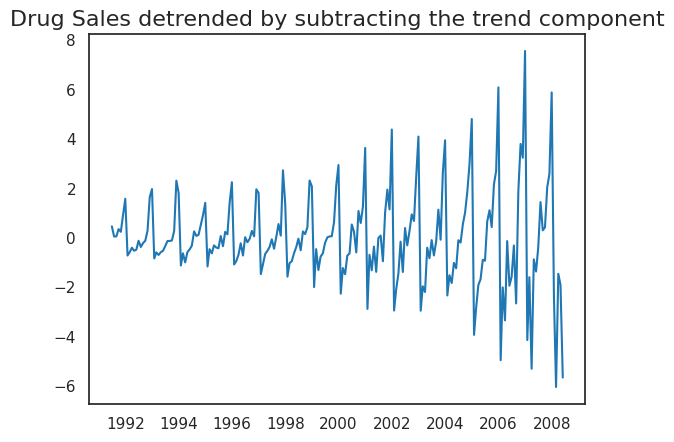

In [36]:
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

Similarly, we can remove the seasonality component:


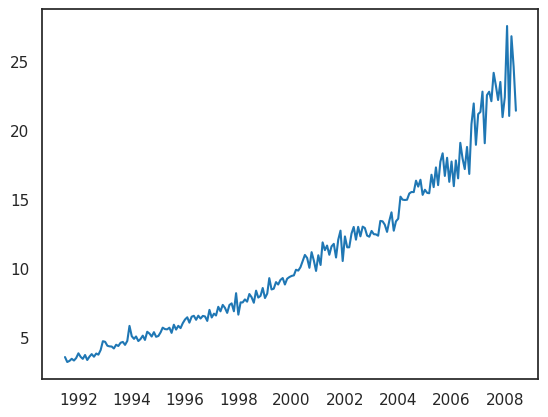

In [37]:
deseasonalized = df.value.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)

#### Time-series imputation


Earlier, we briefly mentioned imputing missing values in a time-series. Sometimes, your time series will have missing dates/times. That means the data was not captured or unavailable for those periods.

Depending on the nature of the series, we can try multiple approaches for imputation:

*   Forward
*   Backward Fill
*   Linear Interpolation, etc.


Let us start by parsing the data frame indices as dates.


In [44]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/a10.csv', parse_dates=['date'], index_col='date')

In [41]:
df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


*   **Forward Imputation**


<Axes: title={'center': 'Forward Fill (MSE: 0.0)'}, xlabel='date'>

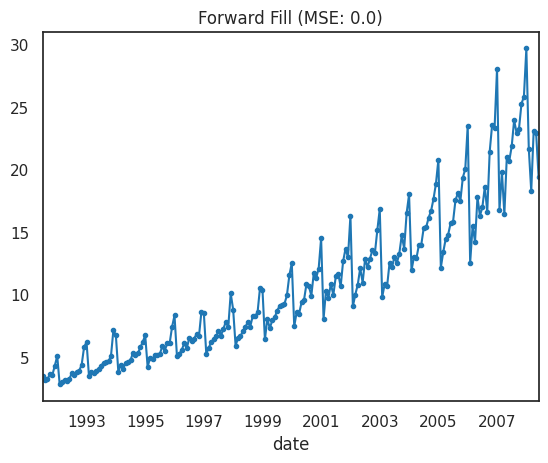

In [45]:
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

df_ffill = df.ffill()
# Print the MSE between imputed value and ground truth
error = np.round(mean_squared_error(df['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", label='Forward Fill', style=".-")

*   **Backward Imputation**


<Axes: title={'center': 'Backward Fill (MSE: 0.0)'}, xlabel='date'>

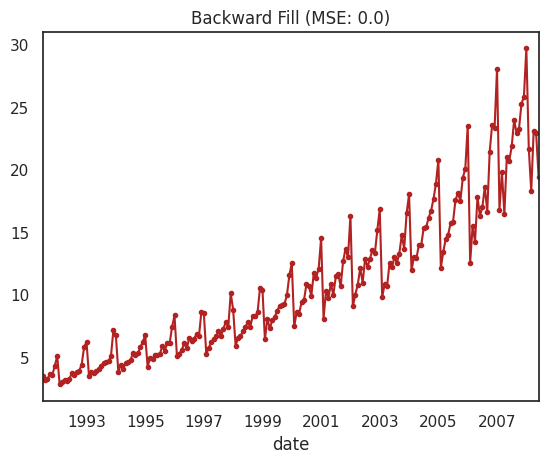

In [46]:
df_bfill = df.bfill()
error = np.round(mean_squared_error(df['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", label='Back Fill', color='firebrick', style=".-")


*   **Linear Interpolation**


<Axes: title={'center': 'Linear Fill (MSE: 0.0)'}, xlabel='date'>

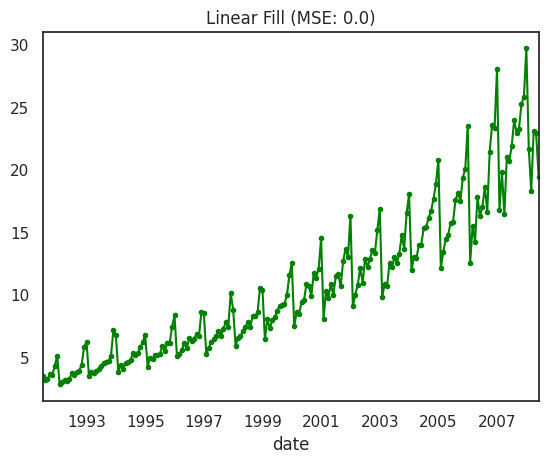

In [47]:
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")",label='Cubic Fill', color='green', style=".-")


Time-series decomposition and imputation are common pre-processing steps used when working on time-series prediction or forecasting tasks.


### Working with text data


In this section, we will be working with a portion of the [Twitter Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) dataset from Kaggle.

> Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative, and Neutral.

The file contains the tweet along with the labels. For the purpose of this lab, we will just explore the dataset, and perform some basic pre-processing.


First, let us download this dataset.


In [48]:
cols = ['Id', 'Entity', 'Sentiment', 'Tweet']
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/twitter_validation.csv', names = cols, header=None)

In [52]:
df.head(2)

,Id,Entity,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


#### Visualizing


Using `groupby` in pandas, we can determine the number of tweets present in each category and plot them.


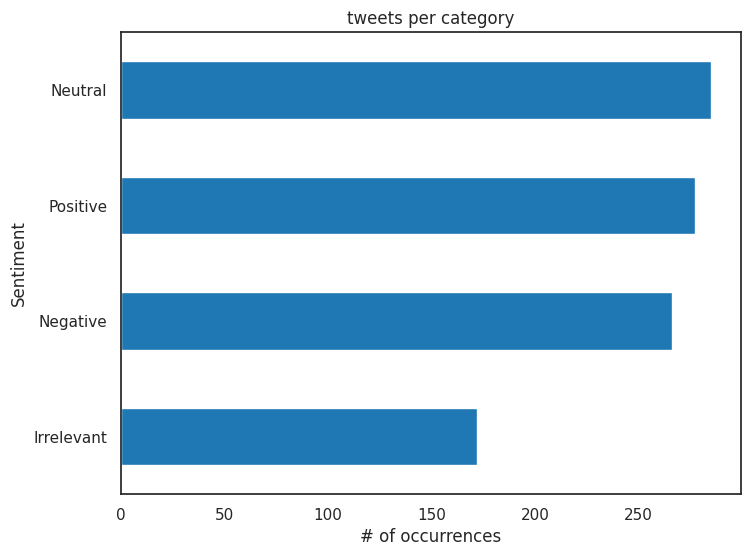

In [53]:
fig = plt.figure(figsize=(8,6))

df.groupby(['Sentiment']).Tweet.count().sort_values().plot.barh(
    ylim=0, title= 'tweets per category')

plt.xlabel('# of occurrences', fontsize = 12);

#### Cleaning up


Now we will focus on preprocessing the raw tweets. This step is important because raw tweets without preprocessing are highly unstructured and contain redundant and often problematic information. They contain tons of noise that should be removed.


Most of the text data is cleaned by following the steps below.

*   Remove punctuations
*   Remove stopwords
*   Tokenization - Converting a sentence into list of words
*   Lemmatization and stemming - Tranforming any form of a word to its root word


Using a corpus of stop-words, including articles, prepositions, and conjunctions, from the Natural Language Toolkit (NLTK) suite, words with little lexical content (such as the, a, also, from, and so on) can be filtered out, for more check out this <a href="https://realpython.com/nltk-nlp-python/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01">link</a>


In [54]:
def remove_punctuation(text):
    regular_punct = list(string.punctuation)
    for punc in regular_punct:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip().lower()

df['Tweet'] = df['Tweet'].apply(remove_punctuation)

In [55]:
def remove_stopwords(tweet):
    en_stops = set(stopwords.words('english'))
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in en_stops])  
    return tweet

df['Tweet'] = df['Tweet'].apply(remove_stopwords)

Tweets can be further processed with tokenization and lemmatization, both of which were performed using packages in the NLTK suite.

Tokenization converts text to analysis relevant word tokens, while lemmatization transforms words to a simpler form, returning the word’s lemma – a canonical form of all its inflectional forms (for example, go represents its inflected forms of goes, going, went, gone).


In [56]:
df['Tweet'] = df['Tweet'].apply(word_tokenize)

In [57]:
def lemma_wordnet(input):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(w) for w in input]

df['Tweet'] = df['Tweet'].apply(lemma_wordnet)

#### Vectorization


Here we explore two techniques for encoding text data into numerical vectors. This is to extract suitable features from processed texts. Both will be implemented using scikitlearn’s CountVectorizer, where `ngram_range` will be set to (1,1) for BoW and (2,2) for B-BoW.


Bag-of-Words (BoW) is a vectorization method to convert variable-length texts into fixed-length vectors, without considering the semantic relation between words.


BoW often results in a very sparse representation. For a large dataset with the vocabulary of a few thousand words, preprocessing text before employing BoW can be useful.


In [58]:
# combine individual words

def combine_text(input):
    combined = ' '.join(input)
    return combined

df['Tweet'] = df['Tweet'].apply(combine_text)

We can plot some of the values we see they are zero


In [59]:
cv = CountVectorizer(ngram_range=(1, 1))
X_train_bow = cv.fit_transform(df['Tweet'])
print(X_train_bow[0:10,0:10].todense())

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [60]:
cv = CountVectorizer(ngram_range=(1, 1))
X_train_bow = cv.fit_transform(df['Tweet'].values.tolist()) 
Y_train_bow = df['Sentiment']
Y_train_bow

0      Irrelevant
1         Neutral
2        Negative
3        Negative
4         Neutral
          ...    
995    Irrelevant
996    Irrelevant
997      Positive
998      Positive
999       Neutral
Name: Sentiment, Length: 1000, dtype: object

Bigram BoW (B-BoW) represents a text document as a weakly ordered collection of contiguous sequences but of two items. It allows for the preservation of more word locality information.


In [61]:
cv_bbow = CountVectorizer(ngram_range=(2, 2))
X_train_bbow = cv_bbow.fit_transform(df['Tweet']) 
Y_train_bbow = df['Sentiment']
Y_train_bbow

0      Irrelevant
1         Neutral
2        Negative
3        Negative
4         Neutral
          ...    
995    Irrelevant
996    Irrelevant
997      Positive
998      Positive
999       Neutral
Name: Sentiment, Length: 1000, dtype: object

Term frequency-inverse document frequency (TF-IDF) is a frequency-based embedding method that
measures the importance of a word in a given document. It can be implemented using the `TfidfVectorizer` function from sklearn.


In [62]:
vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1, 1))
vectorizer.fit(df)
X_train_tfidf = vectorizer.fit_transform(df['Tweet'])
Y_train_tfidf = df['Sentiment'] 
Y_train_tfidf 

0      Irrelevant
1         Neutral
2        Negative
3        Negative
4         Neutral
          ...    
995    Irrelevant
996    Irrelevant
997      Positive
998      Positive
999       Neutral
Name: Sentiment, Length: 1000, dtype: object

# Example 1 - Working with Speech Commands


In this example, we will walk through how to pre-process audio files in the .WAV format. We will be using a portion of the [Speech Commands dataset (Warden, 2018)](https://www.tensorflow.org/datasets/catalog/speech_commands?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up", and "yes".


### Exercise A - Import data set


Let us start by importing a portion of the Speech Commands dataset. The original dataset consists of over 105,000 audio files in the WAV (Waveform) audio file format of people saying 35 different words.


A portion of the dataset is provided by [Tensorflow](http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) as a .zip file. We have modified it further to include just a few test files.


In [63]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/mini_speech_commands.zip")


  0%|          | 0/186 [00:00<?, ?it/s]

Saved to '.'


If you open up the data path, you will see that the dataset's audio clips are stored in eight folders corresponding to each speech command: no, yes, down, go, left, up, right, and stop.


### Exercise B - Extract audio clips


Start off by listing the commands by reading the names of the eight folders that were created earlier.


In [67]:
# Write your solution here:
data_dir="mini_speech_commands"
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != './data/mini_speech_commands/README.md']
commands

array(['go', 'left', 'up', 'right', '.DS_Store', 'yes', 'README.md',
       'stop', 'no'], dtype='<U9')

Now we will extract the names/paths of the audio clips into a file:


In [68]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames

['mini_speech_commands/left/ffd2ba2f_nohash_2.wav',
 'mini_speech_commands/left/ffd2ba2f_nohash_4.wav',
 'mini_speech_commands/left/.DS_Store',
 'mini_speech_commands/left/ffd2ba2f_nohash_1.wav',
 'mini_speech_commands/go/ffd2ba2f_nohash_2.wav',
 'mini_speech_commands/go/.DS_Store',
 'mini_speech_commands/go/ffa76c4a_nohash_0.wav',
 'mini_speech_commands/go/ffd2ba2f_nohash_3.wav',
 'mini_speech_commands/up/ffd2ba2f_nohash_0.wav',
 'mini_speech_commands/up/.DS_Store',
 'mini_speech_commands/up/ffd2ba2f_nohash_3.wav',
 'mini_speech_commands/right/ffd2ba2f_nohash_4.wav',
 'mini_speech_commands/right/.DS_Store',
 'mini_speech_commands/right/ffd2ba2f_nohash_1.wav',
 'mini_speech_commands/right/ffbb695d_nohash_0.wav',
 'mini_speech_commands/no/2da58b32_nohash_4.wav',
 'mini_speech_commands/no/1ecfb537_nohash_3.wav',
 'mini_speech_commands/no/2da58b32_nohash_2.wav',
 'mini_speech_commands/no/2bdbe5f7_nohash_3.wav',
 'mini_speech_commands/no/2bfe70ef_nohash_1.wav',
 'mini_speech_commands/no/0b

Print out the number of audio clips present.


In [69]:
# Write your solution here
num_samples = len(filenames)
print(num_samples)

83


### Exercise C - Plotting audio files


Let's plot an audio waveforms by converting it to a numpy array. We will first pick a test file.


In [70]:
from scipy.io.wavfile import read
test_file_name = '/no/97f4c236_nohash_3.wav'

Now use the `read` function from `scipy.io.wavfile` to read in the wav file as an array.


In [71]:
# Write your solution here
rate, test_file = read(data_dir+test_file_name)


In [79]:
rate # This is amount of the frequency the test audio clip has 16k Hz

16000

Plot the test file.


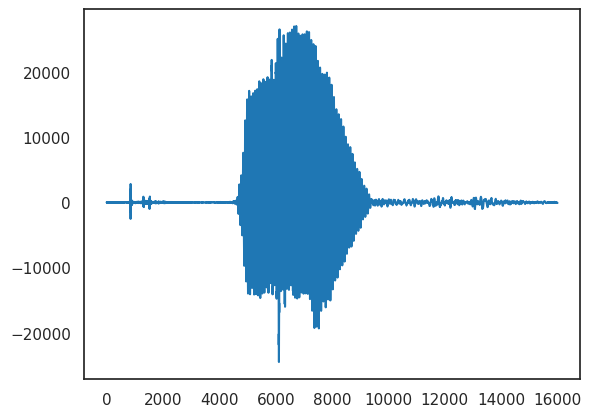

In [72]:
# Write your solution here
plt.plot(test_file)

### Exercise D - Basic pre-processing


We will learn about audio clip pre-processing. Each .WAV file contains time-series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time. In this dataset, the sampling rate of each clip is 16kHz.


We will use the `tf.audio.decode_wav` function to decode the 16-bit WAV files to float tensors, so they are in an easy to use format. The -32768 to 32767 signed 16-bit values will be scaled to -1.0 to 1.0 in float. Let's start off by printing the shape of the tensor returned by tf.audio.decode_wav. It should be \[samples, channels], where channels is 1 for mono or 2 for stereo. The Speech Commands dataset only contains mono recordings.


We will first start by reading the test file as a tensor object.


In [73]:
test_file_tensor = tf.io.read_file(data_dir+'/no/97f4c236_nohash_3.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file_tensor)


In [75]:
# Write your solution here
test_audio, _ = tf.audio.decode_wav(contents=test_file_tensor)
print(test_audio.shape)

(16000, 1)


### Exercise E - Spectrogram


Waveforms in this dataset are represented in the time domain.

Let us look into transforming the waveforms from the time-domain signals into the time-frequency-domain signals by converting it to a spectrogram. A spectrogram shows frequency changes over time and can be represented as 2D images. These images can even be used as input to a neural network.

We will use the `spectrogram` function from `scipy` to do this.


In [76]:
frequencies, times, spectrogram = signal.spectrogram(test_file, rate)

Use the `pcolormesh` and `imshow` functions with time, frequencies, and spectrogram as input to plot the spectrogram.


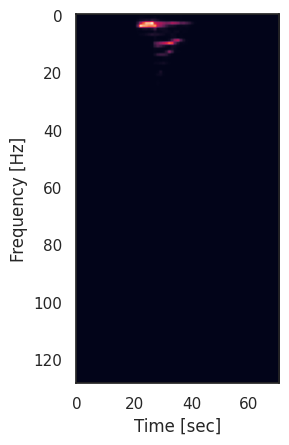

In [77]:
# Write your solution here
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Example 2 - Gene Family Classification


In this example, we will train a Naïve Bayes (NB) classifier on a human DNA sequence dataset to predict the gene family class label. The dataset contains seven different classes shown in the table below.


| gene family                   | number | class label |
| ----------------------------- | ------ | ----------- |
| *G-protein coupled receptors* | 531    | 0           |
| *Tyrosine kynase*             | 534    | 1           |
| *Tyrosine phosphatase*        | 349    | 2           |
| *Synthetase*                  | 672    | 3           |
| *Synthase*                    | 711    | 4           |
| *Ion channel*                 | 240    | 5           |
| *Transcription factor*        | 1343   | 6           |


### Exercise A: Load human DNA data


In [83]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/human_data.txt", overwrite=True)

Saved to '.'


Let us start by reading the tab-separated `human_data.txt` file using Pandas.


In [85]:
# Write your solution here 
human_data = pd.read_csv("human_data.txt", sep="\t")

In [87]:
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Next, we will create a plot to view the class distribution in our data.


Text(0.5, 1.0, 'Class distribution of Human DNA')

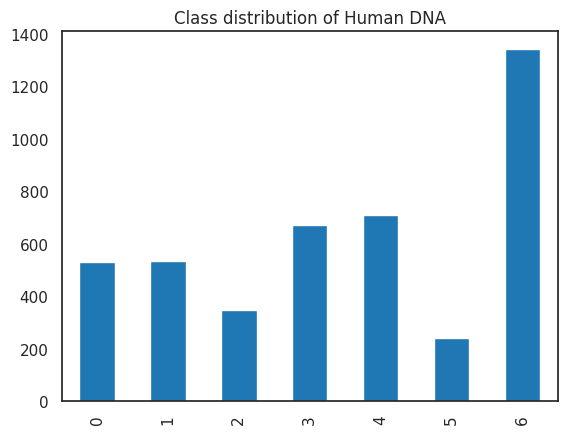

In [86]:
human_data['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Human DNA")

### Exercise B: Sequence of Characters to K-mers


Most ML classification and regression methods expect for the input to be in form of sequences of equal lengths. In this exercise, we will take long biological sequences and break them down into k-mer length overlapping sub-sequences. For example, imagine we have the following sequence:

GTGCCCAGGT

We will write a function that will convert this sequence into overlapping k-mer words for a specified length, or k.


In [88]:
def kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

If we feed our sequence of length 10 to this function, we get the following 5 k-mers.


In [89]:
kmers_funct('GTGCCCAGGT')

['gtgccc', 'tgccca', 'gcccag', 'cccagg', 'ccaggt']

Now, use the `apply()` to apply this function to the entire `human_data`.


In [90]:
# Write your solution here
human_data['words'] = human_data.apply(lambda x: kmers_funct(x['sequence']), axis=1)

To clean up the resulting dataset, we will drop the `sequence` column.

Let us view the first 5 rows.


In [91]:
human_data = human_data.drop('sequence', axis=1)
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


As seen above, the DNA sequence is now changed to lowercase. It has been split into all possible k-mer words of length 6.

We will now join the sub-sequences into a “sentence", as is normally done in many NLP tasks.

This will be done by converting the lists of k-mers for each gene into string sentences of words. We will then use these to create a Bag of Words (BoW) model, to extract a feature matrix from the DNA sequences.


In [92]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
#separate labels
y_human = human_data.iloc[:, 0].values

The target variable contains an array of class values.


In [95]:
print("length of human text seq.:", len(human_texts))
print("length of labels", y_human.shape)

length of human text seq.: 4380
length of labels (4380,)


### Exercise C: Bag-of-Words


In this exercise, you will use the `CountVectorizer()` function to create the Bag of Words model. Use an n-gram count of 4.


In [96]:
from sklearn.feature_extraction.text import CountVectorizer

In [97]:
# Write your solution here
cv = CountVectorizer(ngram_range=(4,4)) 
X = cv.fit_transform(human_texts)

### Exercise D: Multinomial Naïve Bayes Classifier


In the steps above, we learned how to transform the raw DNA sequences into uniform length numerical vectors in the form of k-mer counts and ngrams.

Now, we can go ahead and build a Naïve Bayes classification model for predicting the gene class based on the sequence.

We will hold out 20% of the human data to test our model.


Use `train_test_split` from `sklearn` to split the dataset.


In [98]:
from sklearn.model_selection import train_test_split

In [99]:
# Write your solution here
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_human, 
                                                    test_size = 0.20, 
                                                    random_state=42)

Next, build a simple multinomial naive Bayes classifier.


In [100]:
from sklearn.naive_bayes import MultinomialNB

In [101]:
# Write your solution here
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

Finally, we will make predictions on the held out test set, and print out a classification report.


In [102]:
from sklearn.metrics import classification_report

In [103]:
# Write your solution here 
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       102
           1       1.00      0.98      0.99       106
           2       1.00      1.00      1.00        78
           3       0.99      0.99      0.99       125
           4       0.99      0.96      0.98       149
           5       1.00      1.00      1.00        51
           6       0.96      0.99      0.98       265

    accuracy                           0.98       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.98      0.98      0.98       876

